In [1]:
# Pandas and numpy necessary to do basic data cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# Import and Clean Data

In [2]:
def make_aer_data():
    
    # Import
    df = pd.read_stata("./aer_data/aer_data.dta")

    # Clean up data types
    df['year'] = df.year.dt.year
    for x in ['year','fips','stfips']:
        df[x] = df[x].astype(int)

    # Filter data by year and remove the THREE BIGGEST CITIES WHY DO THEY DO THIS
    df = df[df.year <= 1988]
    df = df[~((df.stfips == 36) & (df.cofips == 61))] 
    df = df[~((df.stfips == 6) & (df.cofips == 37))]
    df = df[~((df.stfips == 17) & (df.cofips == 31))]

    # Make new variables related to urbanization
    df_1960_pcturban = df.loc[df.year == 1960, ['fips','D_60pcturban_t']] \
                         .drop_duplicates('fips') \
                         .rename(columns={'D_60pcturban_t':'_urb'}) \
                         .fillna(0)
    df = df.merge(df_1960_pcturban, how='left', on='fips')
    df['Durb'] = pd.cut(x=df._urb, bins=[0,1,25,50,75,110], right=False, labels=[0,1,25,50,75])

    # Make straight-up dummy variables
    year_dummies   = pd.get_dummies(df.year, prefix="_Iyear", drop_first=True)
    Durb_dummies   = pd.get_dummies(df.Durb, prefix="_IDurb", drop_first=True)
    fips_dummies   = pd.get_dummies(df.fips, prefix="_Ifips", drop_first=True)
    stfips_dummies = pd.get_dummies(df.stfips, prefix="_Istfips", drop_first=True)

    # Make interaction dummies
    for year in np.sort(df.year.unique()):
        for Durb in np.sort(df.Durb.unique()):
            if (f"_Iyear_{year}" in year_dummies.columns) & (f"_IDurb_{Durb}" in Durb_dummies.columns):
                df[f"_IyeaXDur_{year}_{Durb}"] = year_dummies[f"_Iyear_{year}"]*Durb_dummies[f"_IDurb_{Durb}"]
        for stfips in np.sort(df.stfips.unique()):
            if (f"_Iyear_{year}" in year_dummies.columns) & (f"_Istfips_{stfips}" in stfips_dummies.columns):
                df[f"_IyeaXstf_{year}_{stfips}"] = year_dummies[f"_Iyear_{year}"]*stfips_dummies[f"_Istfips_{stfips}"]
    for fips in np.sort(df.fips.unique()):
        df[f"_IfipXyea_{fips}"] = np.where((df['fips']) == fips, df['year'], 0)

    # Make did1 dummies
    for i,did1 in enumerate(np.sort(df.did1.unique())):
        if did1 != -1:
            df[f"_DDdid1_{i+1}"] = np.where(df['did1'] == did1, 1, 0)

    # Make exp1 dummies
    for i,exp1 in enumerate(np.sort(df.exp1.unique())):
        if exp1 != -1:
            df[f"_Texp1_{i+1}"] = np.where(df['exp1'] == exp1, 1, 0)

    # Make exp2 dummies
    for i,exp2 in enumerate(np.sort(df.exp2.unique())):
        if exp2 != -1:
            df[f"_Texp2_{i+1}"] = np.where(df['exp2'] == exp2, 1, 0)

    # Add on year and fips dummies
    df = pd.concat([df,year_dummies],axis=1)
    df = pd.concat([df,fips_dummies],axis=1)

    # Drop missing response values
    df = df[~df['amr'].isna()]

    # Add constant
    df['_const']  = 1
    
    return df

In [3]:
df = make_aer_data()

# Q8(a) - Replication of Table 2, Column 1, Panel A

### Regression Coefficient and SE Estimates

In [4]:
def get_XY_arrays(df,X_cols,Y_var,weight_var,clust_var,fe=True):
        
    # Remove fixed effect means
    fe_df = copy.deepcopy(df)        

    if fe==True:
        grouped_df = df.groupby(clust_var)
        for x_col in X_cols:
            fe_df[x_col] = df[x_col]-grouped_df[x_col].transform('mean')   
        fe_df[Y_var] = df[Y_var]-grouped_df[Y_var].transform('mean')   
        
    # Make arrays 
    Y      = fe_df[Y_var].to_numpy()[:,None]
    X      = fe_df[X_cols].to_numpy()
    weight = fe_df[weight_var].to_numpy()[:,None]
    N      = X.shape[0]
    K      = X.shape[1]

    return Y,X,weight,N,K,fe_df

In [5]:
def run_aer_regression(df,Y,X,weight,N,K,X_cols,Y_var,weight_var):
    
    # Get beta value
    beta = np.linalg.inv(np.multiply(X,weight).T @ X) @ np.multiply(X,weight).T @ Y
    
    # Build the 'meat' of the cluster sandwich SE estimator
    clust_cov_sum = np.zeros((K,K))
    for clust in np.sort(df[clust_var].unique()):

        # Define data just from cluster
        df_clust     = df[df[clust_var] == clust]
        X_clust      = df_clust[X_cols].to_numpy()
        Y_clust      = df_clust[Y_var].to_numpy()[:,None]
        weight_clust = df_clust[weight_var].to_numpy()[:,None]

        # Do weighted cluster robust SE formula
        u_j  = np.multiply((Y_clust - X_clust @ beta), X_clust)
        wu_j = np.multiply(weight_clust, u_j)
        clust_sum = np.sum(wu_j, axis=0)[None,:]
        clust_cov = clust_sum.T @ clust_sum

        # Add to overall 
        clust_cov_sum += clust_cov

    # Get (X'X)^(-1): the 'bread' of the sandwich
    vcov = np.linalg.inv(np.multiply(X,weight).T @ X)

    # Finite-sample correction
    N_weight= weight.sum()
    n_clust = df[clust_var].unique().shape[0]
    qc      = (n_clust/(n_clust-1))*((N_weight-1)/(N_weight-K))

    # Get standard errors of betas
    beta_SE = np.sqrt(np.diag(qc * vcov @ clust_cov_sum @ vcov))
    
    return beta,beta_SE

In [6]:
# Function for getting stars from z-scores
def get_stars(est,est_SE):
    est = est.ravel()
    est_SE = est_SE.ravel()
    stars_all = []
    for i in range(len(est)):    
        stars   = ""
        esti    = est[i]
        est_SEi = est_SE[i]
        Z       = esti/est_SEi
        if abs(Z) > 1.645:
            stars = stars+"*"
        if abs(Z) > 1.959:
            stars = stars+"*"
        if abs(Z) > 2.576:
            stars = stars+"*"
        stars_all.append(stars)
    return stars_all

In [7]:
# Define covariates to use
_Ifips_cols   = [col for col in df if col.startswith('_Ifips')]
_Iyear_cols   = [col for col in df if col.startswith('_Iyear')]
_IyeaXDu_cols = [col for col in df if col.startswith('_IyeaXDu')]
_DD_cols      = [col for col in df if col.startswith('_DD')]
X_cols        = _Iyear_cols+_IyeaXDu_cols+_DD_cols 
fe_cols       = _Ifips_cols
Y_var         = 'amr'
weight_var    = 'popwt'
clust_var     = 'fips'

Y,X,weight,N,K,fe_df = get_XY_arrays(df, X_cols, Y_var, weight_var, clust_var)

In [8]:
beta,beta_SE = run_aer_regression(fe_df, Y,X,weight, N, K, X_cols, Y_var, weight_var)
beta_stars   = get_stars(beta, beta_SE)

### Output Results to Latex

In [9]:
beta_df = pd.DataFrame.from_dict({"Variable":X_cols,
                                  "Coefficient":[str(np.round(beta.ravel()[i],3))+beta_stars[i] 
                                                 for i in range(beta.shape[0])],
                                  "Standard Error":np.round(beta_SE,3)})
beta_df = beta_df[(beta_df['Variable'] == '_DDdid1_2') |
                  (beta_df['Variable'] == '_DDdid1_4') |
                  (beta_df['Variable'] == '_DDdid1_5') | 
                  (beta_df['Variable'] == '_DDdid1_6')]
beta_df["Variable"] = ["Years -6 to -2","Years 0 to 4","Years 5 to 9","Years 10 to 14"]
beta_df.to_latex("./q8_output/table2_col1_panelA_replication.tex", index=False)

In [10]:
beta_df

,Variable,Coefficient,Standard Error
146,Years -6 to -2,0.034,2.844
147,Years 0 to 4,-5.636,3.540
148,Years 5 to 9,-12.045***,4.569
149,Years 10 to 14,-9.384*,5.639


# Q8(c) - Simpler Specification of Table 2, Column 1, Panel A

### Run Regression

In [11]:
# Define covariates to use - this time without year-urban interaction FEs
X_colsC = _Iyear_cols+_DD_cols 

YC,XC,weightC,NC,KC,fe_dfC = get_XY_arrays(df, X_colsC, Y_var, weight_var, clust_var)

In [12]:
betaC,beta_SEC = run_aer_regression(fe_dfC, YC, XC, weightC, NC, KC, X_colsC, Y_var, weight_var)
beta_starsC    = get_stars(betaC, beta_SEC)

### Output Results to Latex

In [13]:
beta_dfC = pd.DataFrame.from_dict({"Variable":X_colsC,
                                   "Coefficient":[str(np.round(betaC.ravel()[i],3))+beta_starsC[i] 
                                                  for i in range(betaC.shape[0])],
                                   "Standard Error":np.round(beta_SEC,3)})
beta_dfC = beta_dfC[(beta_dfC['Variable'] == '_DDdid1_2') |
                    (beta_dfC['Variable'] == '_DDdid1_4') |
                    (beta_dfC['Variable'] == '_DDdid1_5') | 
                    (beta_dfC['Variable'] == '_DDdid1_6')]
beta_dfC["Variable"] = ["Years -6 to -2","Years 0 to 4","Years 5 to 9","Years 10 to 14"]
beta_dfC.to_latex("./q8_output/q8c_table.tex", index=False)

In [14]:
beta_dfC

,Variable,Coefficient,Standard Error
30,Years -6 to -2,2.49,2.829
31,Years 0 to 4,-6.42*,3.460
32,Years 5 to 9,-10.022**,4.321
33,Years 10 to 14,-2.651,5.087


# Q8(d) - Alternate Versions of Figure 5

### Run Regressions

In [15]:
# Define covariates to use - this time without year-urban interaction FEs
_Texp1_cols = [col for col in df if col.startswith('_Texp1')]
_Texp2_cols = [col for col in df if col.startswith('_Texp2')]
X_colsD1a   = _Iyear_cols+_IyeaXDu_cols+_Texp1_cols
X_colsD1b   = _Iyear_cols+_IyeaXDu_cols+_Texp2_cols
X_colsD2a   = _Iyear_cols+_Texp1_cols
X_colsD2b   = _Iyear_cols+_Texp2_cols

# Get matrices for running regressions
YD1a,XD1a,weightD1a,ND1a,KD1a,fe_dfD1a = get_XY_arrays(df,  X_colsD1a, Y_var, weight_var, clust_var)
YD1b,XD1b,weightD1b,ND1b,KD1b,fe_dfD1b = get_XY_arrays(df,  X_colsD1b, Y_var, weight_var, clust_var)
YD2a,XD2a,weightD2a,ND2a,KD2a,fe_dfD2a = get_XY_arrays(df,  X_colsD2a, Y_var, weight_var, clust_var)
YD2b,XD2b,weightD2b,ND2b,KD2b,fe_dfD2b = get_XY_arrays(df,  X_colsD2b, Y_var, weight_var, clust_var)

In [16]:
# Run regressions
betaD1a,beta_SED1a = run_aer_regression(fe_dfD1a, YD1a, XD1a, weightD1a, ND1a, KD1a, X_colsD1a, Y_var, weight_var)
betaD1b,beta_SED1b = run_aer_regression(fe_dfD1b, YD1b, XD1b, weightD1b, ND1b, KD1b, X_colsD1b, Y_var, weight_var)
betaD2a,beta_SED2a = run_aer_regression(fe_dfD2a, YD2a, XD2a, weightD2a, ND2a, KD2a, X_colsD2a, Y_var, weight_var)
betaD2b,beta_SED2b = run_aer_regression(fe_dfD2b, YD2b, XD2b, weightD2b, ND2b, KD2b, X_colsD2b, Y_var, weight_var)

### Format Results for Graphing

In [17]:
# Make dataframe of coefs and standard errors
beta_dfD1a = pd.DataFrame.from_dict({"Variable":X_colsD1a,
                                     "Coefficient":np.round(betaD1a.ravel(),4),
                                     "Standard Error":np.round(beta_SED1a,4)})
beta_dfD1b = pd.DataFrame.from_dict({"Variable":X_colsD1b,
                                     "Coefficient":np.round(betaD1b.ravel(),4),
                                     "Standard Error":np.round(beta_SED1b,4),})
beta_dfD2a = pd.DataFrame.from_dict({"Variable":X_colsD2a,
                                     "Coefficient":np.round(betaD2a.ravel(),4),
                                     "Standard Error":np.round(beta_SED2a,4)})
beta_dfD2b = pd.DataFrame.from_dict({"Variable":X_colsD2b,
                                     "Coefficient":np.round(betaD2b.ravel(),4),
                                     "Standard Error":np.round(beta_SED2b,4),})

beta_dfD1a = beta_dfD1a[beta_dfD1a['Variable'].str.contains('_Texp')]
beta_dfD1b = beta_dfD1b[beta_dfD1b['Variable'].str.contains('_Texp')]
beta_dfD2a = beta_dfD2a[beta_dfD2a['Variable'].str.contains('_Texp')]
beta_dfD2b = beta_dfD2b[beta_dfD2b['Variable'].str.contains('_Texp')]

# Force _Texp1_7 to be 0
newrowa    = pd.DataFrame({'Variable':['_Texp1_7'],'Coefficient':[0.0],'Standard Error':[np.nan]})
newrowb    = pd.DataFrame({'Variable':['_Texp2_7'],'Coefficient':[0.0],'Standard Error':[np.nan]})
newrowc    = pd.DataFrame({'Variable':['_Texp3_7'],'Coefficient':[0.0],'Standard Error':[np.nan]})
beta_dfD1a = pd.concat((beta_dfD1a,newrowa))
beta_dfD2a = pd.concat((beta_dfD2a,newrowa))
beta_dfD1b = pd.concat((beta_dfD1b,newrowb))
beta_dfD2b = pd.concat((beta_dfD2b,newrowb))

# Make time variable for graphs
beta_dfD1a['Time'] = beta_dfD1a['Variable'].str.extract(r'_([0-9]+)$').astype(int)
beta_dfD2a['Time'] = beta_dfD2a['Variable'].str.extract(r'_([0-9]+)$').astype(int)
beta_dfD1b['Time'] = beta_dfD1b['Variable'].str.extract(r'_([0-9]+)$').astype(int)
beta_dfD2b['Time'] = beta_dfD2b['Variable'].str.extract(r'_([0-9]+)$').astype(int)

beta_dfD1a = beta_dfD1a.sort_values('Time').reset_index(drop=True)
beta_dfD2a = beta_dfD2a.sort_values('Time').reset_index(drop=True)
beta_dfD1b = beta_dfD1b.sort_values('Time').reset_index(drop=True)
beta_dfD2b = beta_dfD2b.sort_values('Time').reset_index(drop=True)

beta_dfD1a['Time'] = beta_dfD1a['Time']-8
beta_dfD2a['Time'] = beta_dfD2a['Time']-8
beta_dfD1b['Time'] = beta_dfD1b['Time']-8
beta_dfD2b['Time'] = beta_dfD2b['Time']-8

# Get upper and lower confidence bounds
beta_dfD1a['Upper CI'] = beta_dfD1a['Coefficient']+1.96*beta_dfD1a['Standard Error']
beta_dfD1a['Lower CI'] = beta_dfD1a['Coefficient']-1.96*beta_dfD1a['Standard Error']
beta_dfD2a['Upper CI'] = beta_dfD2a['Coefficient']+1.96*beta_dfD2a['Standard Error']
beta_dfD2a['Lower CI'] = beta_dfD2a['Coefficient']-1.96*beta_dfD2a['Standard Error']

### Make Graph

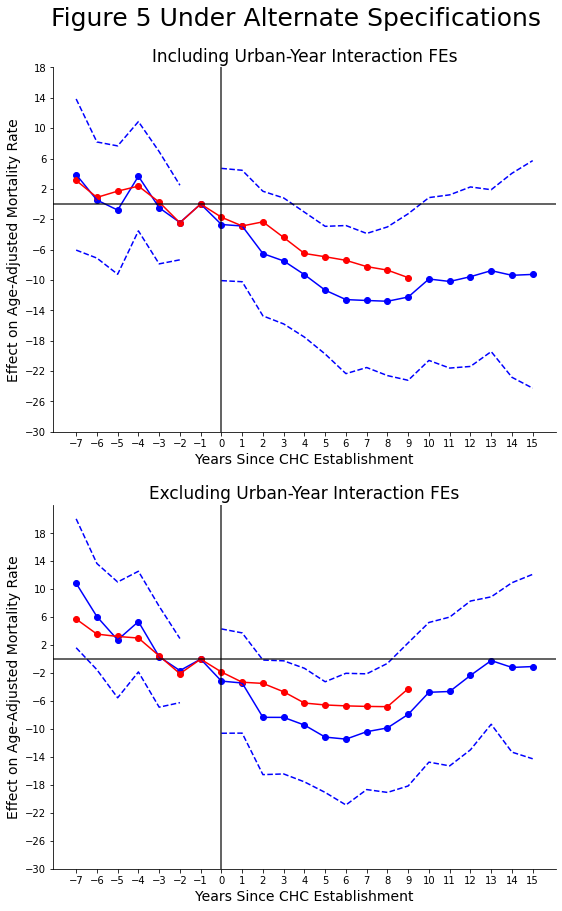

In [18]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(9,14))
ax     = ax.flatten()

# Formatting stuff
plt.subplots_adjust(top=0.92)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Plot 1 main stuff
ax[0].plot(beta_dfD1a['Time'], beta_dfD1a['Coefficient'], color='blue')
ax[0].scatter(beta_dfD1a['Time'], beta_dfD1a['Coefficient'], color='blue')
ax[0].plot(beta_dfD1a['Time'], beta_dfD1a['Upper CI'], linestyle='dashed', color='blue')
ax[0].plot(beta_dfD1a['Time'], beta_dfD1a['Lower CI'], linestyle='dashed', color='blue')
ax[0].plot(beta_dfD1b['Time'], beta_dfD1b['Coefficient'], color='red')
ax[0].scatter(beta_dfD1b['Time'], beta_dfD1b['Coefficient'], color='red')

# Plot 2 main stuff
ax[1].plot(beta_dfD2a['Time'], beta_dfD2a['Coefficient'], color='blue')
ax[1].scatter(beta_dfD2a['Time'], beta_dfD2a['Coefficient'], color='blue')
ax[1].plot(beta_dfD2a['Time'], beta_dfD2a['Upper CI'], linestyle='dashed', color='blue')
ax[1].plot(beta_dfD2a['Time'], beta_dfD2a['Lower CI'], linestyle='dashed', color='blue')
ax[1].plot(beta_dfD2b['Time'], beta_dfD2b['Coefficient'], color='red')
ax[1].scatter(beta_dfD2b['Time'], beta_dfD2b['Coefficient'], color='red')

# Vertical/horizontal lines
ax[0].axhline(y=0, color='black', linestyle='solid', alpha=0.8)
ax[0].axvline(x=0, color='black', linestyle='solid', alpha=0.8)
ax[1].axhline(y=0, color='black', linestyle='solid', alpha=0.8)
ax[1].axvline(x=0, color='black', linestyle='solid', alpha=0.8)

# Axis mess
ax[0].set_xticks(np.arange(-7,16,1))
ax[0].set_yticks(np.arange(-30,22,4))
ax[0].set_xlabel("Years Since CHC Establishment", size=14)
ax[0].set_ylabel("Effect on Age-Adjusted Mortality Rate", size=14)
ax[1].set_xticks(np.arange(-7,16,1))
ax[1].set_yticks(np.arange(-30,22,4))
ax[1].set_xlabel("Years Since CHC Establishment", size=14)
ax[1].set_ylabel("Effect on Age-Adjusted Mortality Rate", size=14)

# Titles
ax[0].set_title("Including Urban-Year Interaction FEs", size=17)
ax[1].set_title("\n\nExcluding Urban-Year Interaction FEs", size=17)
plt.suptitle("Figure 5 Under Alternate Specifications", size=25)

plt.savefig("./q8_output/figure5_alt.png")
plt.show()

# Q8(e) - Direct Approach

In [19]:
def run_simple_regression(X,Y,weight):
    beta = np.linalg.inv(np.multiply(X,weight).T @ X) @ np.multiply(X,weight).T @ Y
    return beta

In [20]:
# EARLIEST YEAR IN DATA = 1959
# LATEST YEAR IN DATA   = 1988
# EARLIEST COHORT       = 1965
# LATEST COHORT         = 1980 (plus never treateds)
# EARLY CHCS CAME 1965-1974
# ALL CHCS CAME 1965-1980
def direct_approach(df):
    
    # Start with earliest cohort and iterate
    att_dict = {}
    for e1 in range(1965,1980+1):

        # Only loop through years for cohort if they exist
        cohort_size = (df['cohort'] == e1).sum()
        if cohort_size > 0:
            for t1 in range(1959,1988+1):

                # Subset to just those necessary for regression
                df_kit1 = copy.deepcopy(df[ 
                     (((df['year'] < e1) | (df['year'] == t1)) & ((df['cohort'] == e1) | (df['cohort'] > t1))) == 1
                ])

                # Make indicator variables for regression
                XE      = np.zeros((df_kit1.shape[0],4))
                XE[:,0] = np.ones(df_kit1.shape[0])
                XE[:,1] = np.array((df_kit1['year'] == t1).astype(int))
                XE[:,2] = np.array((df_kit1['cohort'] == e1).astype(int))
                XE[:,3] = np.array(((df_kit1['year'] == t1) & (df_kit1['cohort'] == e1)).astype(int))
                YE      = np.array(df_kit1[Y_var])[:,None]
                weightE = np.array(df_kit1[weight_var])[:,None]

                # Get ATT_t(e)
                att = run_simple_regression(XE,YE,weightE)[-1,0]
                att_dict[(e1,t1)] = (att,cohort_size)

    # Reorder items to relative time
    relative_diff_dict = {}
    for item in att_dict:
        relative_diff = item[1]-item[0]
        try:
            relative_diff_dict[relative_diff].append(att_dict[item])
        except:
            relative_diff_dict[relative_diff] = [att_dict[item]]

    # Aggregate!
    results = np.zeros((len(relative_diff_dict),3))
    for j,item in enumerate(relative_diff_dict):
        atts    = np.array([i[0] for i in relative_diff_dict[item]])
        weights = np.array([i[1] for i in relative_diff_dict[item]])

        results[j,0] = int(item)
        results[j,1] = np.average(atts, weights=weights)
        results[j,2] = np.sum(weights)

    # Make dataframe from results
    results_df = pd.DataFrame(results,columns=['RT','ATT','N']).sort_values('RT')

    # Combine observations above/below cutoffs
    results_df['RT'] = np.where(results_df['RT'] <= -7, -7, results_df['RT'])
    results_df['RT'] = np.where(results_df['RT'] >= 15, 15, results_df['RT'])

    # Weight aggregated results
    wm = lambda x: np.average(x, weights=results_df.loc[x.index,"N"])
    results_df = results_df.groupby('RT').agg(ATT=("ATT", wm),N=("N","sum")).reset_index()

    return results_df

In [21]:
def block_bootstrap_SEs_direct(df, N_boots):
    
    # Get list of fips
    fips_list = df.fips.unique()
    N_fips    = fips_list.shape[0]

    effects_list = [] 
    for i in range(N_boots):
        
        # Resample at the county leve
        df_sample = df.set_index('fips').loc[np.random.choice(fips_list, N_fips, replace=True)]
        
        # Get results dataframe
        effects_list.append(direct_approach(df_sample))
    
    # Aggregate nicely
    bootstraps = np.zeros((effects.shape[0],effects.shape[1],len(effects_list)))
    for i in range(len(effects_list)):
        bootstraps[:,:,i] = np.array(effects_list[i])
    
    # Return standard deviation of estimators
    return np.std(bootstraps, axis=2)[:,1]

In [22]:
# Fix never treated to have cohort = infinity
df['cohort'] = np.where(df['chc_year_exp'].isna(), np.inf, df['chc_year_exp'])
mydf = copy.deepcopy(df[['fips','year','cohort','amr','popwt']])

In [299]:
effects    = direct_approach(mydf)
effects_SE = block_bootstrap_SEs_direct(mydf, 100)

### Make Graph

In [310]:
# Make into nice dataframe
effects_df = pd.DataFrame({'Time':effects['RT'],
                           'Coefficient':effects['ATT'],
                           'Standard Error':effects_SE})

# Get upper and lower confidence bounds
effects_df['Upper CI'] = effects_df['Coefficient']+1.96*effects_df['Standard Error']
effects_df['Lower CI'] = effects_df['Coefficient']-1.96*effects_df['Standard Error']

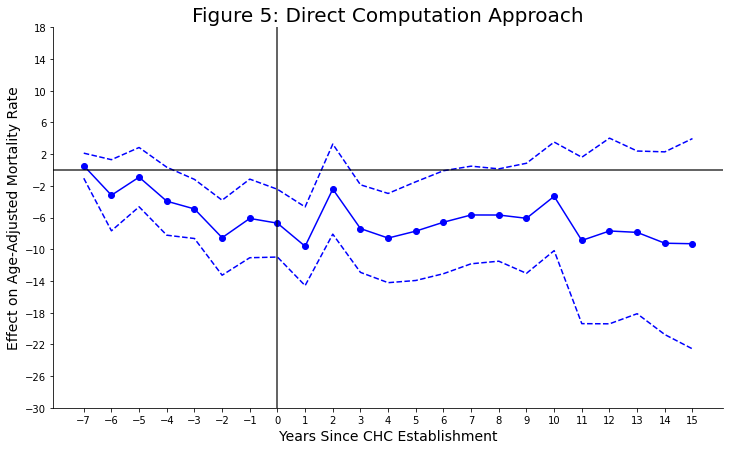

In [313]:
fig,ax = plt.subplots(figsize=(12,7))

# Formatting stuff
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot 1 main stuff
ax.plot(effects_df['Time'], effects_df['Coefficient'], color='blue')
ax.scatter(effects_df['Time'], effects_df['Coefficient'], color='blue')
ax.plot(effects_df['Time'], effects_df['Upper CI'], linestyle='dashed', color='blue')
ax.plot(effects_df['Time'], effects_df['Lower CI'], linestyle='dashed', color='blue')

# Vertical/horizontal lines
ax.axhline(y=0, color='black', linestyle='solid', alpha=0.8)
ax.axvline(x=0, color='black', linestyle='solid', alpha=0.8)

# Axis mess
ax.set_xticks(np.arange(-7,16,1))
ax.set_yticks(np.arange(-30,22,4))
ax.set_xlabel("Years Since CHC Establishment", size=14)
ax.set_ylabel("Effect on Age-Adjusted Mortality Rate", size=14)

# Titles
ax.set_title("Figure 5: Direct Computation Approach", size=20)

# Save out
plt.savefig("./q8_output/q8e_fig5.png")
plt.show()

# Q8(f) - Imputation Approach

In [30]:
def imputation_approach(df):
    
    # Make cohort dummies - leave out never-treated as constant
    for i,cohort in enumerate(np.sort(df.cohort.unique())):
        if cohort < 5000:
            df[f"_Icohort_{int(cohort)}"] = np.where(df['cohort'] == cohort, 1, 0)

    # X columns
    _Icohort_cols = [col for col in df if col.startswith('_Icohort')]

    # Subset to just D_it = 0
    df['D'] = np.where(df['year'] >= df['chc_year_exp'], 1, 0)
    df_d0   = copy.deepcopy(df[df['D'] == 0])
    
    # Make regression matrices
    XF_d0      = np.array(df_d0[_Iyear_cols+_Icohort_cols+['_const']])
    YF_d0      = np.array(df_d0[Y_var])[:,None]
    weightF_d0 = np.array(df_d0[weight_var])[:,None]
    XF      = np.array(df[_Iyear_cols+_Icohort_cols+['_const']])
    YF      = np.array(df[Y_var])[:,None]
    weightF = np.array(df[weight_var])[:,None]
    
    # Get inital beta from regression on untreated
    beta_d0 = run_simple_regression(XF_d0,YF_d0,weightF_d0)
    
    # Add Ydot and Ytilde 
    df['Ydot']   = XF @ beta_d0
    df['Ytilde'] = df[Y_var]-df['Ydot']

    # Drop never treated
    df = df[df['cohort'] < 5000]

    # Do aggregation
    wm           = lambda x: np.average(x, weights=df.loc[x.index,"popwt"])
    impdf        = df.groupby(['cohort','year']).agg(Ytilde=("Ytilde",wm), 
                                                     N=("_const","sum")).reset_index()
    impdf['cohort'] = impdf['cohort'].astype(int)
    impdf['RT']     = impdf['year']-impdf['cohort']
    wm              = lambda x: np.average(x, weights=impdf.loc[x.index,"N"])
    resdf           = impdf.groupby('RT').agg(Ytilde=("Ytilde",wm),N=("N","sum")).reset_index()
    
    # Combine observations above/below cutoffs
    resdf['RT'] = np.where(resdf['RT'] <= -7, -7, resdf['RT'])
    resdf['RT'] = np.where(resdf['RT'] >= 15, 15, resdf['RT'])

    # Weight aggregated results
    wm = lambda x: np.average(x, weights=resdf.loc[x.index,"N"])
    final_df = resdf.groupby('RT').agg(ATT=("Ytilde", wm), N=("N","sum")).reset_index()
    
    return final_df

In [49]:
def block_bootstrap_SEs_direct(df, N_boots):
    
    # Get list of fips
    fips_list = df.fips.unique()
    N_fips    = fips_list.shape[0]

    effects_list = [] 
    for i in range(N_boots):
        
        # Resample at the county level
        df_sample = df.set_index('fips').loc[np.random.choice(fips_list, N_fips, replace=True)]
        df_sample = df_sample.reset_index(drop=True)
        
        # Get results dataframe - SKIP IF LINEAR ALGEBRA ERROR FROM BAD SAMPLE
        try:
            effects_list.append(imputation_approach(df_sample))
        except:
            pass
        
    # Aggregate nicely
    bootstraps = np.zeros((effects_impute.shape[0],effects_impute.shape[1],len(effects_list)))
    for i in range(len(effects_list)):
        bootstraps[:,:,i] = np.array(effects_list[i])
    
    # Return standard deviation of estimators
    return np.std(bootstraps, axis=2)[:,1]

In [46]:
mydf = copy.deepcopy(df[['fips','chc_year_exp','year','popwt','cohort','amr','_const']+_Iyear_cols])

In [50]:
effects_impute    = imputation_approach(mydf)
effects_impute_SE = block_bootstrap_SEs_direct(mydf, 100)

### Make Graph

In [51]:
# Make into nice dataframe
effects_df = pd.DataFrame({'Time':effects_impute['RT'],
                           'Coefficient':effects_impute['ATT'],
                           'Standard Error':effects_impute_SE})

# Get upper and lower confidence bounds
effects_df['Upper CI'] = effects_df['Coefficient']+1.96*effects_df['Standard Error']
effects_df['Lower CI'] = effects_df['Coefficient']-1.96*effects_df['Standard Error']

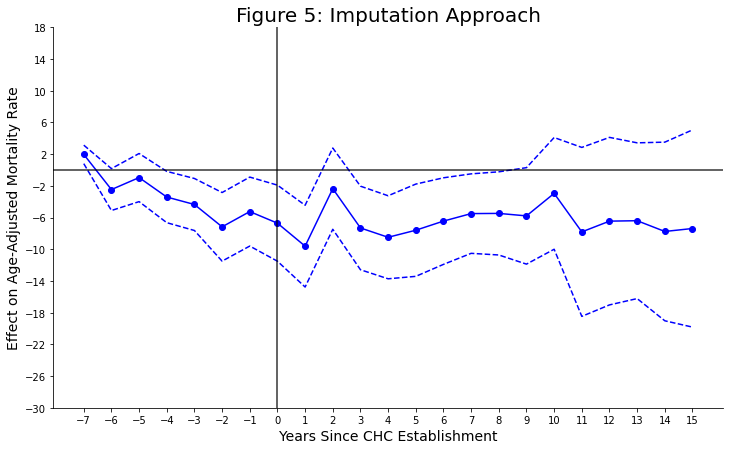

In [53]:
fig,ax = plt.subplots(figsize=(12,7))

# Formatting stuff
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot 1 main stuff
ax.plot(effects_df['Time'], effects_df['Coefficient'], color='blue')
ax.scatter(effects_df['Time'], effects_df['Coefficient'], color='blue')
ax.plot(effects_df['Time'], effects_df['Upper CI'], linestyle='dashed', color='blue')
ax.plot(effects_df['Time'], effects_df['Lower CI'], linestyle='dashed', color='blue')

# Vertical/horizontal lines
ax.axhline(y=0, color='black', linestyle='solid', alpha=0.8)
ax.axvline(x=0, color='black', linestyle='solid', alpha=0.8)

# Axis mess
ax.set_xticks(np.arange(-7,16,1))
ax.set_yticks(np.arange(-30,22,4))
ax.set_xlabel("Years Since CHC Establishment", size=14)
ax.set_ylabel("Effect on Age-Adjusted Mortality Rate", size=14)

# Titles
ax.set_title("Figure 5: Imputation Approach", size=20)

# Save out
plt.savefig("./q8_output/q8f_fig5.png")
plt.show()

# Q8(g) - Add Back Urban Interactions